In [ ]:
"""importing necessary libraries """
import os
import sys
import os, shutil
sys.path.append(r'C:\Program Files (x86)\CST Studio Suite 2023\AMD64\python_cst_libraries')
import cst
import cst.interface
import cst.results
from cst.interface import Project

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt


In [ ]:
"""opening the CST Environment"""
mycst = cst.interface.DesignEnvironment()
"""opening project"""
mycst1=cst.interface.DesignEnvironment.open_project(mycst,  r'\\FS1\Docs3\bharathisha.rao\My Documents\CST_PROJECT\Dipole_2.cst')

In [ ]:
# Seeking Permission to delete the saved Result in a folder
ask=input("Do you wish to delete previous saved files y/n \n")
if ask=="y" or ask=="Y":
    folder = 'C:\\Users\\bharathisha.rao\\Desktop\\Data'
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed')



Do you wish to delete previous saved files y/n 
y


In [ ]:
# import xlwings as xw
# wb=xw.Book("C:\\Users\\bharathisha.rao\\Desktop\\Data\\Book2.xlsm")
# mac=wb.macro("Module1.Main")

# This was to test running vba in python from excel!


In [ ]:
vba_code="""
Sub Main ()


    with WCS
        .AlignWCSWithGlobalCoordinates
     End with

    ' Enter the tag size required
    Dim Tagsize As Long
    Dim Title, Default
    Tagsize = InputBox("Enter the tag area required (mm^2)", "Tag Size", Default)

    ' Enter the number of bits required also if the bits should not exceeds the half size of Tagsize
    Do
        Do
            Dim Bits As Long
            Dim CAL AS Double
            Bits = InputBox("Enter the Number of bits required", "Number of Bits")
            CAL=Int(Tagsize/2)

            If Bits > CAL Then
                MsgBox "Invalid Bits Specified.Please enter the Bits ranges from 1 - " & Round(CAL,2)
            Else
               Exit Do
            End If
        Loop

       ' Select dielectric
        Do
        Substrate = InputBox("Enter the Substrate material (Air or FR-4 (lossy)) ", "Substrate")
        If Substrate = "Air" Then
            Dielectric = 1.0
            Exit Do
        ElseIf Substrate = "FR-4 (lossy)" Then
            Dielectric = 4.3
            Exit Do
        End If
        MsgBox "Invalid Substrate. Please enter either Air or FR-4 (lossy)"
        Loop

        ' Enter the substrate thickness
        Dim SubThickness As Double
        SubThickness = InputBox("Enter the Substrate Thickness (mm)", "Substrate Thickness")


        ' Enter the Material
        Dim Metal As String
        Do
            Metal = InputBox("Enter the Dipole Material as Copper (annealed) or PEC", "Dipole Metal")
            If Metal="Copper (annealed)" Or Metal="PEC" Then Exit Do
            MsgBox "Invalid Metal.Please enter either Copper (annealed)or PEC"
        Loop

        ' Effective Tagsize after removing 2mm
        Tagsize = Tagsize - 2


        ' Enter the frequency both start and stop also defining the Bandwidth
        Dim startfrequency As Double
        Dim stopfrequency As Double
        Dim BW As Double
        Dim SBW As Double
        SBW=0.8
        BW=SBW*Bits
        startfrequency=Round((3e8/((2*Tagsize/1000)*sqr(Dielectric)))/1e9,2)
        stopfrequency=startfrequency+BW

        ' Specifying the operating frequency and Bandwidth through Message
        Dim Msg
        Msg = "The Calculated Tag operating Frequency will be approximately from " & startfrequency-1 & "GHz to " & stopfrequency & "GHz with a Bandwidth of " & BW & "GHz. Calculated frequency's location of the Peaks are: "
        Dim k
        Dim b_k As Double
        For k=1 To Bits
            b_k=startfrequency +(SBW*(k-1))
            Msg= Msg & "b" & k & "=" & b_k & "GHz, "
        Next k
        MsgBox Msg

        ' Set Frequency
        with Solver
            .Reset
            .FrequencyRange  8,17
            .FrequencySamples 1000
        End With

        ' Create FR-4 lossy Material
        With Material
            .Reset
            .Name "FR-4 (lossy)"
            .Type ("Normal")
            .Epsilon ("4.3")
            .TanD ("0.025")
            .ThermalConductivity ("0.3")
            .Colour (0.8,0.5,0.5)
            .Create
        End With

        ' Create the dipoles for each bit

        Dim i As Long
        Dim j As Long
        Dim Length As Double
        Dim Bitgenerator As String
        Dim f As Double
        Dim fmax As Double

        ' if the component exists, delete it
        On Error Resume Next
        SelectTreeItem "Components"
        If Err.Number = 0 Then
            With Component
                .Delete "component"
            End With
        End If
        On Error GoTo 0

        ' if the individual dipole components exist, delete them
        For j = 0 To Bits
            On Error Resume Next
            SelectTreeItem "component:" & j
            If Err.Number = 0 Then
                With Component
                    .Delete "component" & j
                End With
            End If
            On Error GoTo 0
        Next j

        Tagsize = Tagsize + 2

        ' Create the substrate
        With Brick
            .Reset
            .Name "Substrate"
            .Component "component"
            .Material Substrate
            .Xrange Tagsize / 2, -Tagsize / 2
            .Yrange Tagsize / 2, -Tagsize / 2
            .Zrange SubThickness / 2, -SubThickness / 2
            .Create
        End With
        ' Calculating the frequency of dipole based on tagsize
        f=(3e8/((2*Tagsize/1000)*Sqr(Dielectric)))/1e9
        fmax=(3e8/((2*Tagsize/1000)*Sqr(Dielectric)))/1e9+BW

        For i = 1 To Bits
            Length= (3e8/(2*f*1e9*Sqr(Dielectric)))*1000 -2
            With Brick
                .Reset
                .Name "Dipole_" & i & "Bit"
                .Component "component"
                .Material Metal
                .Xrange -Tagsize/2+(i-1)*(Tagsize/Bits)+(Tagsize/(2*Bits))+0.25, (-Tagsize/2+(i-1)*(Tagsize/Bits)+(Tagsize/(2*Bits)))-0.5
                .Yrange Length/2, -Length/2
                .Zrange SubThickness/2,SubThickness/2+0.04
                .Create
            End With
            f=f+SBW
        Next i

        With Solver
            .start
        End With

        ' Saving the RCS RESULTS
        SelectTreeItem "1D Results\Probes\RCS\RCS (Cartesian) (0 0 20)(Abs) [pw]
        Dim file As String
        file="C:\\Users\\bharathisha.rao\\Desktop\\Data_plot\\Tag" & ".csv"
        With ASCIIExport
            .Reset
            .FileName file
            .Mode ("FixedNumber")
            .SetfileType("csv")
            .Execute
        End With

        ' Asking User Preference
        Dim Out As String
        Out = InputBox("Did you like the RCS Result? Do you want to Proceed? y/n ", "Out")
        If Out="y" Or Out="Y" Then Exit Do
        Loop

    ' Deleting the the component
    with Component
        .Delete "component"
    End With

    For j=0 To (2^Bits)-1

        Bitgenerator=Dec2Bin(j,Bits)


        ' Create the substrate
        With Brick
            .Reset
            .Name "Substrate"
            .Component "component" & j
            .Material Substrate
            .Xrange Tagsize / 2, -Tagsize / 2
            .Yrange Tagsize / 2, -Tagsize / 2
            .Zrange SubThickness / 2, -SubThickness / 2
            .Create
        End With

        f=(3e8/((2*Tagsize/1000)*sqr(Dielectric)))/1e9
        fmax=(3e8/((2*Tagsize/1000)*sqr(Dielectric)))/1e9+BW

        For i = 1 To Bits
            Length= (3e8/(2*f*1e9*sqr(Dielectric)))*1000
            With Brick
                .Reset
                .Name "Dipole_" & i & "Bit"
                .Component "component" & j

                If Mid(Bitgenerator,i,1)="1" Then
                    .Material Metal
                Else
                    .Material "Air"
                End If

                .Xrange -Tagsize/2+(i-1)*(Tagsize/Bits)+(Tagsize/(2*Bits))+0.25, (-Tagsize/2+(i-1)*(Tagsize/Bits)+(Tagsize/(2*Bits)))-0.25
                .Yrange Length/2-1, -Length/2+1
                .Zrange SubThickness/2,SubThickness/2+0.04
                .Create
            End With
            f=f+SBW
        Next i

       ' Running the Solver
        With Solver
            .start
        End With

        ' Saving the RCS result based in Bits
        SelectTreeItem "1D Results\Probes\RCS\RCS (Cartesian) (0 0 20)(Abs) [pw]"
        Dim fileName As String
        fileName="C:\\Users\\bharathisha.rao\\Desktop\\Data\\Tag" & j & ".csv"
        With ASCIIExport
            .Reset
            .FileName fileName
            .Mode ("FixedNumber")
            .SetfileType("csv")
            .Execute
        End With

        ' Asking user for cylindrical bending
       Dim deform As String
       deform=InputBox("Do you want to perform Cylindrical Deformation ? y/n", "deform")
       If deform="y" Or deform="Y" Then
           Dim D As Double
           Do
           D=InputBox("Enter the Cylindrical Deformation Radii (mm)? ", "D")
           If D>(Tagsize/(2*3.14)) Then Exit Do
           MsgBox "Enter the Value above half size of TagSize"
           Loop
           With Bending
               For i=1 to Bits
                   .Reset
                   .Shape "component" & j & ":" & "Dipole_" & i & "Bit"
                   .ReferenceSolid  "component" & j & ":Substrate"
                   .Centralized "True"
                   .Radius D
                   .FlexBend
               Next i
           End With
           With Bending
               .Reset
               .Shape "component" & j & ":Substrate"
               .Centralized "True"
               .Radius D
               .FlexBend
           End With

           With Solver
               .start
           End With

            SelectTreeItem "1D Results\Probes\RCS\RCS (Cartesian) (0 0 20)(Abs) [pw]"
            Dim fileName1 As String
            fileName1="C:\\Users\\bharathisha.rao\\Desktop\\Data\\Tag" & j & "deformation1"& ".csv"
            With ASCIIExport
                .Reset
                .FileName fileName1
                .Mode ("FixedNumber")
                .SetfileType("csv")
                .Execute
            End With

        End If
        with Component
            .Delete "component" & j
        End With


    Next j


End Sub

' Function to convert Decimal value to binary

Function Dec2Bin(ByVal DecimalIn As Long, Optional NumberOfBits As Long) As String
    Dim BinaryStr As String
    BinaryStr = ""

    Do While DecimalIn > 0
        BinaryStr = (DecimalIn Mod 2) & BinaryStr
        DecimalIn = DecimalIn \ 2
    Loop

    If NumberOfBits > 0 Then
        If Len(BinaryStr) > NumberOfBits Then
            Dec2Bin = "Error - Number exceeds specified bit size"
        Else
            Dec2Bin = Right(String(NumberOfBits, "0") & BinaryStr, NumberOfBits)
        End If
    Else
        Dec2Bin = BinaryStr
    End If
End Function

"""
mycst1.schematic.execute_vba_code(vba_code, timeout=None)



Do you want to visualize yes/no
y
You can visualize if you require to check any Tag Signature
Do you want to stop visualizing y/n
n
Do you want to visualize yes/no
y
You can visualize if you require to check any Tag Signature
Do you want to stop visualizing y/n
n
Do you want to visualize yes/no
yes
Do you wish to visualize any Tag Signature. Please Enter the the  Value for the Tag43


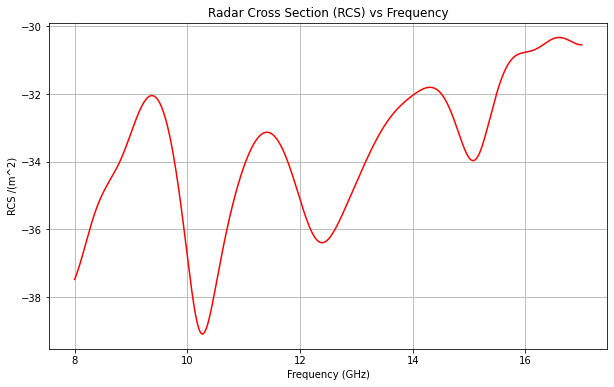

Do you want to stop visualizing y/n
n
Do you want to visualize yes/no
y
You can visualize if you require to check any Tag Signature
Do you want to stop visualizing y/n
n
Do you want to visualize yes/no
yes
Do you wish to visualize any Tag Signature. Please Enter the the  Value for the Tag53


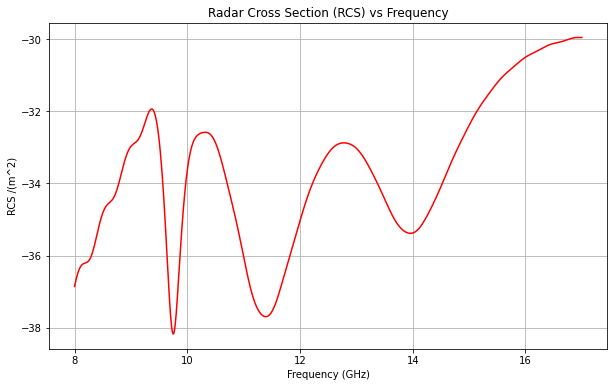

Do you want to stop visualizing y/n
y


In [ ]:
#Visualizing the RCS Results in a loop


def visulaize(user_visualize):
    user_visualize=input("Do you want to visualize yes/no\n")
    user_visualize=user_visualize.lower()
    if user_visualize=="yes":
        user_input=input('Do you wish to visualize any Tag Signature. Please Enter the the  Value for the Tag')
        file_path = f"C:\\Users\\bharathisha.rao\\Desktop\\Data\\Tag{user_input}.csv"

        colspecs = [(0, 27), (27, 60)]
        data = pd.read_fwf(file_path, colspecs=colspecs, skiprows=2, header=None)
        data.columns = ['Frequency (GHz)', 'RCS (dB)']
        data['Frequency (GHz)'] = pd.to_numeric(data['Frequency (GHz)'])
        data['RCS (dB)'] = pd.to_numeric(data['RCS (dB)'])

        # Drop rows with NaN values
        data.dropna(inplace=True)
        # Plot the data
        plt.figure(figsize=(10, 6))
        plt.plot(data['Frequency (GHz)'], data['RCS (dB)'], color='red')
        plt.title('Radar Cross Section (RCS) vs Frequency')
        plt.xlabel('Frequency (GHz)')
        plt.ylabel('RCS /(m^2)')
        plt.grid(True)
        plt.show()
        # Clear the plot
        plt.clf()
        plt.close()

    else :
        print("You can visualize if you require to check any Tag Signature")


while True:
    visulaize("yes")
    user_stop=input("Do you want to stop visualizing y/n\n")
    if user_stop=="y":
        break




In [ ]:
#This is to merge the tag bit generated signature csv file into one merged csv file
# and formatting it based on the requirements


# In[7]:

def merge_csv_files_with_samples(folder_path):
    merged_data = []
    files = []

    # Iterate over the files in the folder
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            if file != "0.csv":
                files.append(file)

    for file in files:
        file_path = os.path.join(folder_path, file)
         # Spliting the TagID and Deformation Value through splitting the name of the saved result
        parts = file.replace("Tag", "").split("deformation")
        tagid = parts[0].replace(".csv", "").strip()
        deformation = parts[1].replace(".csv", "").strip() if len(parts) > 1 else "0"
        #column specifing to separate two columns specified in one reading it through fixed width format .
        colspecs = [(0, 27), (27, 60)]
        data = pd.read_fwf(file_path, colspecs=colspecs, skiprows=2, header=None)
        data.columns = ['Frequency (GHz)', 'RCS (dB)']

        data['Tag ID'] = tagid
        data['Deformation'] = deformation
        data['Sample'] = data.index

        merged_data.append(data)

    if merged_data:
        combined_df = pd.concat(merged_data, ignore_index=True)

        # Convert Tag ID to integer for sorting
        combined_df['Tag ID'] = combined_df['Tag ID'].astype(int)
        combined_df['Deformation'] = combined_df['Deformation'].astype(int)

        # Create the pivot table
        pivot_table = combined_df.pivot_table(index=['Tag ID', 'Deformation'], columns='Sample',
                                              values='RCS (dB)', aggfunc='first').reset_index()

        # Sort
        pivot_table.sort_values(by=['Tag ID', 'Deformation'], inplace=True)

        # Update column names
        new_columns = ['Tag ID', 'Deformation']
        for col in pivot_table.columns[2:]:
            new_columns.append(str(col))
        pivot_table.columns = new_columns

        output_file = os.path.join(folder_path, 'merged_output.csv')
        pivot_table.to_csv(output_file, index=False)

        print(f"Merged file saved to {output_file}")


folder_path = 'C:\\Users\\bharathisha.rao\\Desktop\\Data'
merge_csv_files_with_samples(folder_path)


Merged file saved to C:\Users\bharathisha.rao\Desktop\Data\merged_output.csv


In [1]:
#Finalized code.
#other try out method

In [2]:

# vba_code="""
# Sub Main ()

#      with WCS
#         .AlignWCSWithGlobalCoordinates
#      End with

#     ' Enter the tag size required
#     Dim Tagsize As Long
#     Dim Title, Default
#     Tagsize = InputBox("Enter the tag area required (mm^2)", "Tag Size", Default)

#     ' Enter the number of bits required also if the bits should not exceeds the half size of Tagsize
#     Do
#         Do
#             Dim Bits As Long
#             Dim CAL AS Double
#             Bits = InputBox("Enter the Number of bits required", "Number of Bits")
#             CAL=Int(Tagsize/2)

#             If Bits > CAL Then
#                 MsgBox "Invalid Bits Specified.Please enter the Bits ranges from 1 - " & Round(CAL,2)
#             Else
#                Exit Do
#             End If
#         Loop

#         ' Select dielectric
#         Do
#         Substrate = InputBox("Enter the Substrate material (Air or FR-4 (lossy)) ", "Substrate")
#         If Substrate = "Air" Then
#             Dielectric = 1.0
#             Exit Do
#         ElseIf Substrate = "FR-4 (lossy)" Then
#             Dielectric = 4.3
#             Exit Do
#         End If
#         MsgBox "Invalid Substrate. Please enter either Air or FR-4 (lossy)"
#         Loop

#         ' Enter the substrate thickness
#         Dim SubThickness As Double
#         SubThickness = InputBox("Enter the Substrate Thickness (mm)", "Substrate Thickness")


#         ' Enter the Material
#         Dim Metal As String
#         Do
#             Metal = InputBox("Enter the Dipole Material as Copper (annealed) or PEC", "Dipole Metal")
#             If Metal="Copper (annealed)" Or Metal="PEC" Then Exit Do
#             MsgBox "Invalid Metal.Please enter either Copper (annealed)or PEC"
#         Loop

#         ' Effective Tagsize after removing 2mm
#         Tagsize = Tagsize - 2


#         ' Enter the frequency both start and stop also defining the Bandwidth
#         Dim startfrequency As Double
#         Dim stopfrequency As Double
#         Dim BW As Double
#         Dim SBW As Double
#         SBW=0.8
#         BW=SBW*Bits
#         startfrequency=Round((3e8/((2*Tagsize/1000)*sqr(Dielectric)))/1e9,2)
#         stopfrequency=startfrequency+BW

#         ' Specifying the operating frequency and Bandwidth through Message
#         Dim Msg
#         Msg = "The Calculated Tag operating Frequency will be approximately from " & startfrequency-1 & "GHz to " & stopfrequency & "GHz with a Bandwidth of " & BW & "GHz. Calculated frequency's location of the Peaks are: "
#         Dim k
#         Dim b_k As Double
#         For k=1 To Bits
#             b_k=startfrequency +(SBW*(k-1))
#             Msg= Msg & "b" & k & "=" & b_k & "GHz, "
#         Next k
#         MsgBox Msg

#         ' Set Frequency
#         with Solver
#             .Reset
#             .FrequencyRange  8,17
#             .FrequencySamples 1000
#         End With

#         ' Create FR-4 lossy Material
#         With Material
#             .Reset
#             .Name "FR-4 (lossy)"
#             .Type ("Normal")
#             .Epsilon ("4.3")
#             .TanD ("0.025")
#             .ThermalConductivity ("0.3")
#             .Colour (0.8,0.5,0.5)
#             .Create
#         End With

#         ' Create the dipoles for each bit

#         Dim i As Long
#         Dim j As Long
#         Dim Length As Double
#         Dim Bitgenerator As String
#         Dim f As Double
#         Dim fmax As Double

#         ' if the component exists, delete it
#         On Error Resume Next
#         SelectTreeItem "Components"
#         If Err.Number = 0 Then
#             With Component
#                 .Delete "component"
#             End With
#         End If
#         On Error GoTo 0

#         ' if the individual dipole components exist, delete them
#         For j = 0 To Bits
#             On Error Resume Next
#             SelectTreeItem "component:" & j
#             If Err.Number = 0 Then
#                 With Component
#                     .Delete "component" & j
#                 End With
#             End If
#             On Error GoTo 0
#         Next j

#         Tagsize = Tagsize + 2

#         ' Create the substrate
#         With Brick
#             .Reset
#             .Name "Substrate"
#             .Component "component"
#             .Material Substrate
#             .Xrange Tagsize / 2, -Tagsize / 2
#             .Yrange Tagsize / 2, -Tagsize / 2
#             .Zrange SubThickness / 2, -SubThickness / 2
#             .Create
#         End With
#         ' Calculating the frequency of dipole based on tagsize
#         f=(3e8/((2*Tagsize/1000)*Sqr(Dielectric)))/1e9
#         fmax=(3e8/((2*Tagsize/1000)*Sqr(Dielectric)))/1e9+BW

#         For i = 1 To Bits
#             Length= (3e8/(2*f*1e9*Sqr(Dielectric)))*1000 -2
#             With Brick
#                 .Reset
#                 .Name "Dipole_" & i & "Bit"
#                 .Component "component"
#                 .Material Metal
#                 .Xrange -Tagsize/2+(i-1)*(Tagsize/Bits)+(Tagsize/(2*Bits))+0.25, (-Tagsize/2+(i-1)*(Tagsize/Bits)+(Tagsize/(2*Bits)))-0.5
#                 .Yrange Length/2, -Length/2
#                 .Zrange SubThickness/2,SubThickness/2+0.04
#                 .Create
#             End With
#             f=f+SBW
#         Next i

#         With Solver
#             .start
#         End With

#         ' Saving the RCS RESULTS
#         SelectTreeItem "1D Results\Probes\RCS\RCS (Cartesian) (0 0 20)(Abs) [pw]
#         Dim file As String
#         file="C:\\Users\\bharathisha.rao\\Desktop\\Data_plot\\Tag" & ".csv"
#         With ASCIIExport
#             .Reset
#             .FileName file
#             .Mode ("FixedNumber")
#             .SetfileType("csv")
#             .Execute
#         End With

#         ' Asking User Preference
#         Dim Out As String
#         Out = InputBox("Did you like the RCS Result? Do you want to Proceed? y/n ", "Out")
#         If Out="y" Or Out="Y" Then Exit Do
#         Loop

#     ' Deleting the the component
#     with Component
#         .Delete "component"
#     End With

#     For j=0 To (2^Bits)-1

#         Bitgenerator=Dec2Bin(j,Bits)


#         ' Create the substrate
#         With Brick
#             .Reset
#             .Name "Substrate"
#             .Component "component" & j
#             .Material Substrate
#             .Xrange Tagsize / 2, -Tagsize / 2
#             .Yrange Tagsize / 2, -Tagsize / 2
#             .Zrange SubThickness / 2, -SubThickness / 2
#             .Create
#         End With

#         f=(3e8/((2*Tagsize/1000)*sqr(Dielectric)))/1e9
#         fmax=(3e8/((2*Tagsize/1000)*sqr(Dielectric)))/1e9+BW

#         For i = 1 To Bits
#             Length= (3e8/(2*f*1e9*sqr(Dielectric)))*1000
#             With Brick
#                 .Reset
#                 .Name "Dipole_" & i & "Bit"
#                 .Component "component" & j

#                 If Mid(Bitgenerator,i,1)="1" Then
#                     .Material Metal
#                 Else
#                     .Material "Air"
#                 End If

#                 .Xrange -Tagsize/2+(i-1)*(Tagsize/Bits)+(Tagsize/(2*Bits))+0.25, (-Tagsize/2+(i-1)*(Tagsize/Bits)+(Tagsize/(2*Bits)))-0.25
#                 .Yrange Length/2-1, -Length/2+1
#                 .Zrange SubThickness/2,SubThickness/2+0.04
#                 .Create
#             End With
#             f=f+SBW
#         Next i

#        ' Running the Solver
#         With Solver
#             .start
#         End With

#         ' Saving the RCS result based in Bits
#         SelectTreeItem "1D Results\Probes\RCS\RCS (Cartesian) (0 0 20)(Abs) [pw]"
#         Dim fileName As String
#         fileName="C:\\Users\\bharathisha.rao\\Desktop\\Data_plot\\Tag" & j & ".csv"
#         With ASCIIExport
#             .Reset
#             .FileName fileName
#             .Mode ("FixedNumber")
#             .SetfileType("csv")
#             .Execute
#         End With

#         with WCS
#             .AlignWCSWithGlobalCoordinates
#         End with

#         ' Asking user for cylindrical bending
#        Dim deform As String
#        deform=InputBox("Do you want to perform Cylindrical Deformation ? y/n", "deform")
#        If deform="y" Or deform="Y" Then
#            Dim D As Double
#            Do
#            D=InputBox("Enter the Cylindrical Deformation Radii (mm)? ", "D")
#            If D>(Tagsize/(2*3.14)) Then Exit Do
#            MsgBox "Enter the Value above half size of TagSize"
#            Loop

#             With Bending
#                For i=1 to Bits
#                    .Reset
#                    .Shape "component" & j & ":" & "Dipole_" & i & "Bit"
#                    .ReferenceSolid  "component" & j & ":Substrate"
#                    .Centralized "True"
#                    .Radius "D"
#                    .FlexBend
#                Next i
#            End With

#            With Bending
#                .Reset
#                .Shape "component" & j & ":Substrate"
#                .Centralized "True"
#                .Radius "-90"
#                .FlexBend
#            End With


#            With Solver
#                .start
#            End With

#             SelectTreeItem "1D Results\Probes\RCS\RCS (Cartesian) (0 0 20)(Abs) [pw]"
#             Dim fileName1 As String
#             fileName1="C:\\Users\\bharathisha.rao\\Desktop\\Data_plot\\Tag" & j & "deformation1"& ".csv"
#             With ASCIIExport
#                 .Reset
#                 .FileName fileName1
#                 .Mode ("FixedNumber")
#                 .SetfileType("csv")
#                 .Execute
#             End With

#         End If
#         with Component
#             .Delete "component" & j
#         End With


#     Next j


# End Sub

# ' Function to convert Decimal value to binary

# Function Dec2Bin(ByVal DecimalIn As Long, Optional NumberOfBits As Long) As String
#     Dim BinaryStr As String
#     BinaryStr = ""

#     Do While DecimalIn > 0
#         BinaryStr = (DecimalIn Mod 2) & BinaryStr
#         DecimalIn = DecimalIn \ 2
#     Loop

#     If NumberOfBits > 0 Then
#         If Len(BinaryStr) > NumberOfBits Then
#             Dec2Bin = "Error - Number exceeds specified bit size"
#         Else
#             Dec2Bin = Right(String(NumberOfBits, "0") & BinaryStr, NumberOfBits)
#         End If
#     Else
#         Dec2Bin = BinaryStr
#     End If
# End Function

# """
# mycst1.schematic.execute_vba_code(vba_code, timeout=None)

# """"

In [ ]:
#CYLINDRICAL BENDING  EXPERIMENTS

In [ ]:
vba_code="""
Sub Main ()

     with WCS
        .AlignWCSWithGlobalCoordinates
     End with

    ' Enter the tag size required
    Dim Tagsize As Long
    Dim Title, Default
    Tagsize = InputBox("Enter the tag area required (mm^2)", "Tag Size", Default)

    ' Enter the number of bits required also if the bits should not exceeds the half size of Tagsize

        Do
            Dim Bits As Long
            Dim CAL AS Double
            Bits = InputBox("Enter the Number of bits required", "Number of Bits")
            CAL=Int(Tagsize/2)

            If Bits > CAL Then
                MsgBox "Invalid Bits Specified.Please enter the Bits ranges from 1 - " & Round(CAL,2)
            Else
               Exit Do
            End If
        Loop

        ' Select dielectric
        Do
        Substrate = InputBox("Enter the Substrate material (Air or FR-4 (lossy)) ", "Substrate")
        If Substrate = "Air" Then
            Dielectric = 1.0
            Exit Do
        ElseIf Substrate = "FR-4 (lossy)" Then
            Dielectric = 4.3
            Exit Do
        End If
        MsgBox "Invalid Substrate. Please enter either Air or FR-4 (lossy)"
        Loop

        ' Enter the substrate thickness
        Dim SubThickness As Double
        SubThickness = InputBox("Enter the Substrate Thickness (mm)", "Substrate Thickness")


        ' Enter the Material
        Dim Metal As String
        Do
            Metal = InputBox("Enter the Dipole Material as Copper (annealed) or PEC", "Dipole Metal")
            If Metal="Copper (annealed)" Or Metal="PEC" Then Exit Do
            MsgBox "Invalid Metal.Please enter either Copper (annealed)or PEC"
        Loop

        ' Effective Tagsize after removing 2mm
        Tagsize = Tagsize - 2


        ' Enter the frequency both start and stop also defining the Bandwidth
        Dim startfrequency As Double
        Dim stopfrequency As Double
        Dim BW As Double
        Dim SBW As Double
        SBW=0.8
        BW=SBW*Bits
        startfrequency=Round((3e8/((2*Tagsize/1000)*sqr(Dielectric)))/1e9,2)
        stopfrequency=startfrequency+BW

        ' Specifying the operating frequency and Bandwidth through Message
        Dim Msg
        Msg = "The Calculated Tag operating Frequency will be approximately from " & startfrequency-1 & "GHz to " & stopfrequency & "GHz with a Bandwidth of " & BW & "GHz. Calculated frequency's location of the Peaks are: "
        Dim k
        Dim b_k As Double
        For k=1 To Bits
            b_k=startfrequency +(SBW*(k-1))
            Msg= Msg & "b" & k & "=" & b_k & "GHz, "
        Next k
        MsgBox Msg

        ' Set Frequency
        with Solver
            .Reset
            .FrequencyRange  8,17
            .FrequencySamples 1000
        End With

        ' Create FR-4 lossy Material
        With Material
            .Reset
            .Name "FR-4 (lossy)"
            .Type ("Normal")
            .Epsilon ("4.3")
            .TanD ("0.025")
            .ThermalConductivity ("0.3")
            .Colour (0.8,0.5,0.5)
            .Create
        End With

        ' Create the dipoles for each bit

        Dim i As Long
        Dim j As Long
        Dim Length As Double
        Dim Bitgenerator As String
        Dim f As Double
        Dim fmax As Double

        ' if the component exists, delete it
        On Error Resume Next
        SelectTreeItem "Components"
        If Err.Number = 0 Then
            With Component
                .Delete "component"
            End With
        End If
        On Error GoTo 0

        ' if the individual dipole components exist, delete them
        For j = 0 To 1000
            On Error Resume Next
            SelectTreeItem "component:" & j
            If Err.Number = 0 Then
                With Component
                    .Delete "component" & j
                End With
            End If
            On Error GoTo 0
        Next j

        Tagsize = Tagsize + 2

        ' Create the substrate
        With Brick
            .Reset
            .Name "Substrate"
            .Component "component"
            .Material Substrate
            .Xrange Tagsize / 2, -Tagsize / 2
            .Yrange Tagsize / 2, -Tagsize / 2
            .Zrange SubThickness / 2, -SubThickness / 2
            .Create
        End With
        ' Calculating the frequency of dipole based on tagsize
        f=(3e8/((2*Tagsize/1000)*Sqr(Dielectric)))/1e9
        fmax=(3e8/((2*Tagsize/1000)*Sqr(Dielectric)))/1e9+BW

        For i = 1 To Bits
            Length= (3e8/(2*f*1e9*Sqr(Dielectric)))*1000 -2
            With Brick
                .Reset
                .Name "Dipole_" & i & "Bit"
                .Component "component"
                .Material Metal
                .Xrange -Tagsize/2+(i-1)*(Tagsize/Bits)+(Tagsize/(2*Bits))+0.25, (-Tagsize/2+(i-1)*(Tagsize/Bits)+(Tagsize/(2*Bits)))-0.5
                .Yrange Length/2, -Length/2
                .Zrange SubThickness/2,SubThickness/2+0.04
                .Create
            End With
            f=f+SBW
        Next i

        With Cylinder
            .Reset
            .Name ("cylinder1")
            .Component ("component1")
            .Material ("PEC")
            .Axis ("x")
            .Outerradius (30)
            .Zcenter (-30)
            .Xrange (15, -15)
            .Yrange (0, 0)
            .Zrange (0,0)
            .Create
        End With

        With Bending
            .Reset
            .Shape  "Components$component"
            .Solid "component1:cylinder1"
            .Faces "0,0,0,0"
            .FlexBending "True"
            .Bend
        End With


End Sub
"""
mycst1.schematic.execute_vba_code(vba_code, timeout=None)



RuntimeError: An error occurred while trying to execute execute_vba_code:
CST::PublicException$$Error in VBA code:

Sub Main ()

     with WCS 
        .AlignWCSWithGlobalCoordinates
     End with
        
    ' Enter the tag size required
    Dim Tagsize As Long
    Dim Title, Default
    Tagsize = InputBox("Enter the tag area required (mm^2)", "Tag Size", Default)
    
    ' Enter the number of bits required also if the bits should not exceeds the half size of Tagsize 
    
        Do
            Dim Bits As Long
            Dim CAL AS Double
            Bits = InputBox("Enter the Number of bits required", "Number of Bits")
            CAL=Int(Tagsize/2)

            If Bits > CAL Then
                MsgBox "Invalid Bits Specified.Please enter the Bits ranges from 1 - " & Round(CAL,2)
            Else
               Exit Do
            End If
        Loop

        ' Select dielectric
        Do
        Substrate = InputBox("Enter the Substrate material (Air or FR-4 (lossy)) ", "Substrate")
        If Substrate = "Air" Then
            Dielectric = 1.0
            Exit Do
        ElseIf Substrate = "FR-4 (lossy)" Then
            Dielectric = 4.3
            Exit Do
        End If
        MsgBox "Invalid Substrate. Please enter either Air or FR-4 (lossy)"
        Loop

        ' Enter the substrate thickness
        Dim SubThickness As Double
        SubThickness = InputBox("Enter the Substrate Thickness (mm)", "Substrate Thickness")


        ' Enter the Material
        Dim Metal As String
        Do
            Metal = InputBox("Enter the Dipole Material as Copper (annealed) or PEC", "Dipole Metal")
            If Metal="Copper (annealed)" Or Metal="PEC" Then Exit Do
            MsgBox "Invalid Metal.Please enter either Copper (annealed)or PEC"
        Loop
        
        ' Effective Tagsize after removing 2mm
        Tagsize = Tagsize - 2


        ' Enter the frequency both start and stop also defining the Bandwidth
        Dim startfrequency As Double
        Dim stopfrequency As Double
        Dim BW As Double
        Dim SBW As Double
        SBW=0.8
        BW=SBW*Bits
        startfrequency=Round((3e8/((2*Tagsize/1000)*sqr(Dielectric)))/1e9,2)
        stopfrequency=startfrequency+BW
        
        ' Specifying the operating frequency and Bandwidth through Message
        Dim Msg
        Msg = "The Calculated Tag operating Frequency will be approximately from " & startfrequency-1 & "GHz to " & stopfrequency & "GHz with a Bandwidth of " & BW & "GHz. Calculated frequency's location of the Peaks are: " 
        Dim k
        Dim b_k As Double
        For k=1 To Bits  
            b_k=startfrequency +(SBW*(k-1))
            Msg= Msg & "b" & k & "=" & b_k & "GHz, " 
        Next k
        MsgBox Msg
        
        ' Set Frequency
        with Solver 
            .Reset
            .FrequencyRange  8,17
            .FrequencySamples 1000
        End With    

        ' Create FR-4 lossy Material
        With Material
            .Reset
            .Name "FR-4 (lossy)"
            .Type ("Normal")
            .Epsilon ("4.3")
            .TanD ("0.025")
            .ThermalConductivity ("0.3")
            .Colour (0.8,0.5,0.5)
            .Create
        End With

        ' Create the dipoles for each bit

        Dim i As Long
        Dim j As Long
        Dim Length As Double
        Dim Bitgenerator As String
        Dim f As Double
        Dim fmax As Double
        
        ' if the component exists, delete it
        On Error Resume Next
        SelectTreeItem "Components"
        If Err.Number = 0 Then
            With Component
                .Delete "component"
            End With
        End If
        On Error GoTo 0
        
        ' if the individual dipole components exist, delete them 
        For j = 0 To 1000 
            On Error Resume Next 
            SelectTreeItem "component:" & j 
            If Err.Number = 0 Then 
                With Component 
                    .Delete "component" & j 
                End With 
            End If 
            On Error GoTo 0 
        Next j
        
        Tagsize = Tagsize + 2
        
        ' Create the substrate
        With Brick
            .Reset
            .Name "Substrate"
            .Component "component" 
            .Material Substrate
            .Xrange Tagsize / 2, -Tagsize / 2
            .Yrange Tagsize / 2, -Tagsize / 2
            .Zrange SubThickness / 2, -SubThickness / 2
            .Create
        End With
        ' Calculating the frequency of dipole based on tagsize 
        f=(3e8/((2*Tagsize/1000)*Sqr(Dielectric)))/1e9
        fmax=(3e8/((2*Tagsize/1000)*Sqr(Dielectric)))/1e9+BW 

        For i = 1 To Bits
            Length= (3e8/(2*f*1e9*Sqr(Dielectric)))*1000 -2
            With Brick
                .Reset
                .Name "Dipole_" & i & "Bit"
                .Component "component" 
                .Material Metal   
                .Xrange -Tagsize/2+(i-1)*(Tagsize/Bits)+(Tagsize/(2*Bits))+0.25, (-Tagsize/2+(i-1)*(Tagsize/Bits)+(Tagsize/(2*Bits)))-0.5
                .Yrange Length/2, -Length/2
                .Zrange SubThickness/2,SubThickness/2+0.04 
                .Create
            End With
            f=f+SBW
        Next i
           
        With Cylinder
            .Reset
            .Name ("cylinder1")
            .Component ("component1")
            .Material ("PEC")
            .Axis ("x")
            .Outerradius (30)
            .Zcenter (-30)
            .Xrange (15, -15)
            .Yrange (0, 0)
            .Zrange (0,0)
            .Create
        End With
        
        With Bending
            .Reset
            .Shape  "Components$component"
            .Solid "component1:cylinder1"
            .Faces "0,0,0,0"
            .FlexBending "True"
            .Bend
        End With
        
 
End Sub


(&H8000ffff) The specified shape does not exist: Components$component
(.Bend)(Line:181)